# CTR Prediction using Logistic Regression

This is a minor project based on online advertising data.  
The aim is to predict whether a user will click on an advertisement using Logistic Regression.



In [4]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)

import joblib


In [5]:
import pandas as pd

df = pd.read_csv("/content/advertising.csv")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [6]:
# Checking dataset shape

df.shape

# Checking dataset information

df.info()

# Checking for missing values

df.isnull().sum()

# Checking target variable distribution

df['Clicked on Ad'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB


,count
Clicked on Ad,
0,500
1,500


## Dataset Overview

The dataset contains user demographic and usage information related to online ads.  
The target variable shows whether a user clicked on an ad (1) or not (0).


In [7]:
# Renaming target column for convenience

df.rename(columns={'Clicked on Ad': 'Clicked'}, inplace=True)

# Extracting hour from timestamp

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour

# Selecting relevant features

features = [
    'Daily Time Spent on Site',
    'Age',
    'Area Income',
    'Daily Internet Usage',
    'Male',
    'Hour'
]

X = df[features]
y = df['Clicked']


In [8]:
# Splitting data into training and testing sets (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Checking class balance after split

y_train.value_counts(normalize=True)


,proportion
Clicked,
1,0.5
0,0.5


## Model Training

Since this is a binary classification problem, Logistic Regression is used.  
The model is trained using scaled features to improve performance.


In [9]:
# Creating pipeline with scaling and logistic regression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000))
])

# Performing stratified cross validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')

cv_scores.mean()


np.float64(0.9893061224489796)

In [10]:
# Training logistic regression model

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=2000))])

In [11]:
# Predicting labels and probabilities on test data

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]


In [12]:
# Calculating evaluation metrics required by the project

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

accuracy, precision, recall, roc_auc


(0.9733333333333334,
 0.9797297297297297,
 0.9666666666666667,
 np.float64(0.9917333333333334))

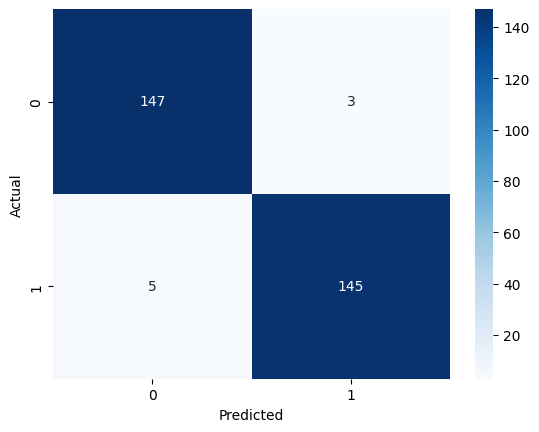

In [13]:
# Plotting confusion matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
# Displaying detailed classification report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       150
           1       0.98      0.97      0.97       150

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



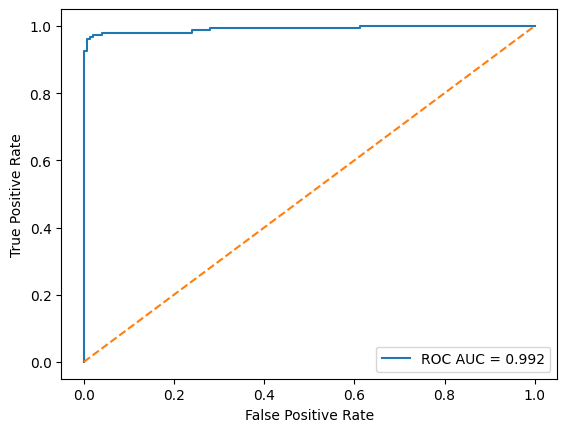

In [15]:
# Plotting ROC curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


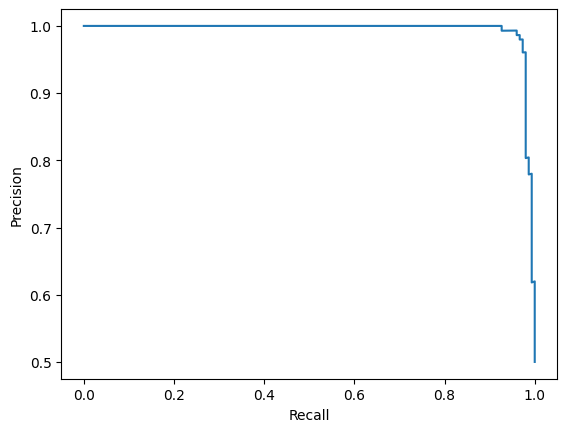

In [16]:
# Plotting Precision-Recall curve

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [17]:
# Checking precision and recall for different probability thresholds

thresholds = np.linspace(0.1, 0.9, 9)
results = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    results.append([
        t,
        precision_score(y_test, preds),
        recall_score(y_test, preds)
    ])

pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall'])


,Threshold,Precision,Recall
0,0.1,0.875000,0.980000
1,0.2,0.936306,0.980000
2,0.3,0.960784,0.980000
3,0.4,0.973333,0.973333
4,0.5,0.979730,0.966667
5,0.6,0.986395,0.966667
6,0.7,0.993056,0.953333
7,0.8,0.993056,0.953333
8,0.9,0.992958,0.940000


In [18]:
# Extracting coefficients and calculating odds ratios

model = pipe.named_steps['model']
coeffs = model.coef_[0]
odds_ratios = np.exp(coeffs)

pd.DataFrame({
    'Feature': features,
    'Odds Ratio': odds_ratios
}).sort_values(by='Odds Ratio', ascending=False)


,Feature,Odds Ratio
1,Age,3.245349
5,Hour,0.810546
4,Male,0.713839
2,Area Income,0.220295
3,Daily Internet Usage,0.099727
0,Daily Time Spent on Site,0.062394


In [19]:
# Saving trained model for future use

joblib.dump(pipe, "logistic_ctr_model.joblib")


['logistic_ctr_model.joblib']

## Conclusion

A Logistic Regression model was built to predict ad click behaviour.  
The results show that user data can be useful for improving ad targeting and reducing wasted ad spend.
